# BuildingPit Element

In [62]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "..")
# sys.path.insert(1, r"c:/GitHub/timml")
import timml

In [63]:
timml.__file__

'..\\timml\\__init__.py'

## Parameters

In [64]:
kh = 2.
f_ani = 0.05
kv = f_ani*kh
ctop = 800.

In [65]:
ztop = 0.
z_well = -13.
z_dw = -15.
z_extra = z_dw - 15.
zbot = -60.

In [66]:
l = 40.  # lengte compartiment in m
b = 30.   # breedte compartiment in m

h_bem = -6.21  # m
offset = 5.  # distance bemaling from sheetpiles in m

In [67]:
xy = [(-l/2, -b/2), (l/2, -b/2), (l/2, b/2), (-l/2, b/2), (-l/2, -b/2)]

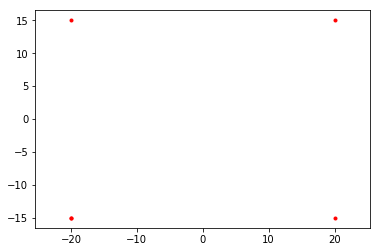

In [68]:
# for (x, y) in xy2:
#     p1, = plt.plot(x, y, "ko", label="inhom pts")
for (x, y) in xy:
    p2, = plt.plot(x, y, "r.", label="building pit pts")
# plt.legend([p1, p2], [i.get_label() for i in [p1, p2]], loc="best")
plt.axis("equal");
plt.show()

## Model

In [70]:
z = np.array([ztop+1, ztop, z_dw, z_dw, z_extra, z_extra, zbot])
dz = z[1::2] - z[2::2]
dz

array([15., 15., 30.])

In [71]:
kh_arr = kh * np.ones(dz.shape)

In [72]:
c = np.r_[np.array([ctop]), dz[:-1]/(2*kv) + dz[1:]/(2*kv)]
c

array([800., 150., 225.])

In [79]:
ml = timml.ModelMaq(kaq=kh_arr, z=z, c=c, topboundary="semi", hstar=0.0)

layers = np.arange(np.sum(z_dw <= ml.aq.zaqbot))
last_lay_dw = layers[-1]

inhom = timml.BuildingPit(ml, xy, kaq=kh_arr, z=z[1:], topboundary="conf", 
                          c=c[1:], order=4, ndeg=3, layers=layers)

timml.HeadLineSink(ml, x1=-l/2+offset, y1=b/2-offset, x2=l/2-offset, y2=b/2-offset, hls=h_bem, 
                   layers=np.arange(last_lay_dw+1))
timml.HeadLineSink(ml, x1=-l/2+offset, y1=0, x2=l/2-offset, y2=0, hls=h_bem, 
                   layers=np.arange(last_lay_dw+1))
timml.HeadLineSink(ml, x1=-l/2+offset, y1=-b/2+offset, x2=l/2-offset, y2=-b/2+offset, hls=h_bem, 
                   layers=np.arange(last_lay_dw+1))

# ml.solve_mt(nthreads=6)
ml.solve()

Qtot = 0.

for e in ml.elementlist:
    if e.name == "HeadLineSink":
        Qtot += e.discharge()

print("Debiet =", np.round(Qtot.sum(), 2), "m3/dag")

y = np.linspace(-b/2-25, b/2+1100, 201)
hl = ml.headalongline(np.zeros(201), y, layers=[0])
y_5cm = np.interp(-0.05, ml.headalongline(np.zeros(201), y, layers=0).squeeze(), y, right=np.nan)
print("Afstand tot 5 cm verlaging =", np.round(y_5cm, 2), "m")

# Q_arr[mi] = Qtot.sum()
# y5cm_arr[mi] = y_5cm

Number of elements, Number of equations: 21 , 124
.....................
solution complete
Debiet = 47.5 m3/dag
Afstand tot 5 cm verlaging = 180.0 m


Visualizations


In [80]:
x = np.linspace(-l/2-25, l/2+1100, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[last_lay_dw, last_lay_dw+1])

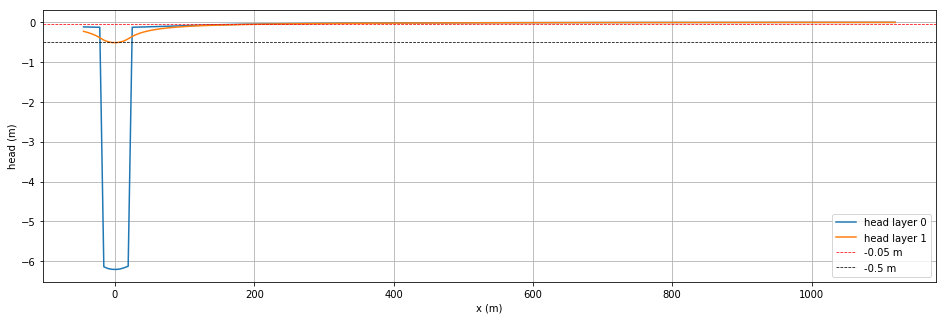

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(x, hl[0].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw+1))

ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(b=True)

In [82]:
xoffset = 15
zoffset = 15
x1, x2, y1, y2 = [-l/2-xoffset, -l/2+xoffset, 0, 0]
nudge = 1e-6
n = 301

In [83]:
# plot head contour cross-sections
h = ml.headalongline(np.linspace(x1 + nudge, x2 - nudge, n),
                     np.linspace(y1 + nudge, y2 - nudge, n))
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
xg = np.linspace(0, L, n)+x1

zg = 0.5 * (ml.aq.zaqbot + ml.aq.zaqtop)
zg = np.hstack((ml.aq.zaqtop[0], zg, ml.aq.zaqbot[-1]))
h = np.vstack((h[0], h, h[-1]))

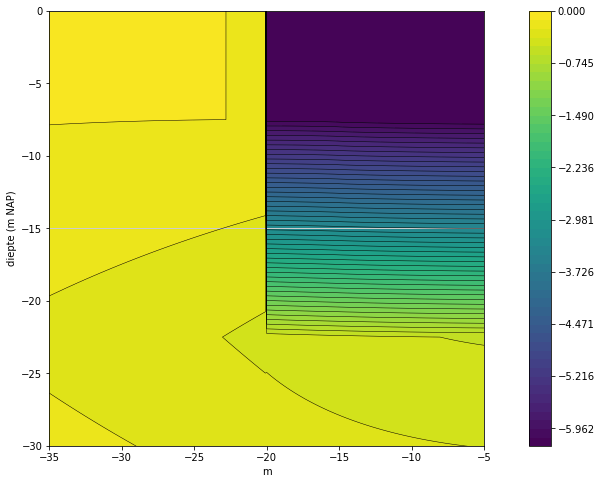

In [84]:
levels = np.linspace(h_bem, -0.0, 51)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ml.plot(win=[x1, x2, y1, y2], orientation="ver", newfig=False)
# ml.vcontoursf1D(x1, x2, n, levels=101, newfig=False, ax=ax, color="r")

cf = ax.contourf(xg, zg, h, levels)
cs = ax.contour(xg, zg, h, levels, colors="k", linewidths=0.5)
# cs2 = ax.contour(xg, zg2, h2, levels, colors="r", linewidths=0.5, linestyles="dashed")

# plt.clabel(cs, fmt="%.2f")
# plt.clabel(cs2, fmt="%.2f")

ax.set_ylim(z_dw-zoffset, z_dw+zoffset)
ax.set_ylabel("diepte (m NAP)");
ax.set_xlabel("m")
ax.set_aspect("equal")

plt.colorbar(cf, ax=ax)
plt.show()

More layers

In [45]:
n = 11  # aantal laagjes boven en onder damwand

In [46]:
dz_i_top = (z_well-z_dw)/np.sum(np.arange(n+1))
dz_i_bot = (z_dw-z_extra)/np.sum(np.arange(2*n+1))

In [47]:
z_layers_top = np.cumsum(np.arange(n)*dz_i_top)
z_layers_bot = np.cumsum(np.arange(2*n)*dz_i_bot)

In [48]:
zgr = np.r_[z_dw + z_layers_top[::-1], (z_dw-z_layers_bot)[1:]]

In [49]:
z4 = np.r_[np.array([ztop+1, ztop, z_well, z_well]), np.repeat(zgr, 2, 0), z_extra, z_extra, zbot]
# z4 = np.r_[np.array([ztop+1, ztop, z_well]), np.repeat(zgr, 2, 0)[1:-1]]

In [50]:
dz4 = z4[1:-1:2] - z4[2::2]

In [51]:
kh_arr = kh * np.ones(dz4.shape)

In [52]:
c = np.r_[np.array([ctop]), dz4[:-1]/(2*kv) + dz4[1:]/(2*kv)]

In [53]:
ml = timml.ModelMaq(kaq=kh_arr, z=z4, c=c, topboundary="semi", hstar=0.0)

layers = np.arange(np.sum(z_dw <= ml.aq.zaqbot))
last_lay_dw = layers[-1]
inhom = timml.BuildingPit(ml, xy, kaq=kh_arr, z=z4[1:], topboundary="conf", 
                          c=c[1:], order=4, ndeg=3, layers=layers)

wlayers = np.arange(np.sum(z_well <= ml.aq.zaqbot))

timml.HeadLineSink(ml, x1=-l/2+offset, y1=b/2-offset, x2=l/2-offset, y2=b/2-offset, hls=h_bem, 
                   layers=wlayers)
timml.HeadLineSink(ml, x1=-l/2+offset, y1=0, x2=l/2-offset, y2=0, hls=h_bem, 
                   layers=wlayers, order=5)
timml.HeadLineSink(ml, x1=-l/2+offset, y1=-b/2+offset, x2=l/2-offset, y2=-b/2+offset, hls=h_bem, 
                   layers=wlayers);

ml.solve_mt(nthreads=6)

Qtot = 0.

for e in ml.elementlist:
    if e.name == "HeadLineSink":
        Qtot += e.discharge()

print("Debiet =", np.round(Qtot.sum(), 2), "m3/dag")

y = np.linspace(-b/2-25, b/2+1100, 201)
hl = ml.headalongline(np.zeros(201), y, layers=[0])
y_5cm = np.interp(-0.05, ml.headalongline(np.zeros(201), y, layers=0).squeeze(), y, right=np.nan)
print("Afstand tot 5 cm verlaging =", np.round(y_5cm, 2), "m")

Number of elements, Number of equations: 21 , 1409
.....................
solution complete
Debiet = 67.32 m3/dag
Afstand tot 5 cm verlaging = 241.51 m


In [54]:
last_lay_dw = layers[-1]

In [60]:
x = np.linspace(-l/2-25, l/2+1, 201)
# x = np.linspace(-l/2-25, l/2+1100, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[0, last_lay_dw, last_lay_dw+1])

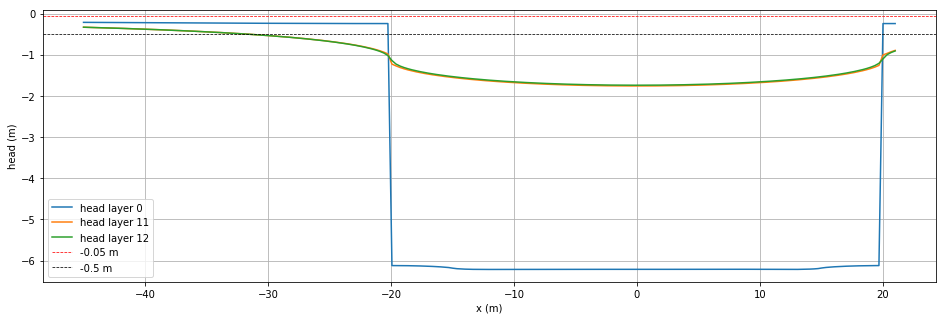

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(x, hl[0].squeeze(), label="head layer 0")
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[2].squeeze(), label="head layer {}".format(last_lay_dw+1))

ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(b=True)

In [57]:
xoffset = 15
zoffset = 15
x1, x2, y1, y2 = [-l/2-xoffset, -l/2+xoffset, 0, 0]
nudge = 1e-6
n = 301

In [58]:
# plot head contour cross-sections
h = ml.headalongline(np.linspace(x1 + nudge, x2 - nudge, n),
                     np.linspace(y1 + nudge, y2 - nudge, n))
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
xg = np.linspace(0, L, n) + x1

zg = 0.5 * (ml.aq.zaqbot + ml.aq.zaqtop)
zg = np.hstack((ml.aq.zaqtop[0], zg, ml.aq.zaqbot[-1]))
h = np.vstack((h[0], h, h[-1]))

(-20, -5)

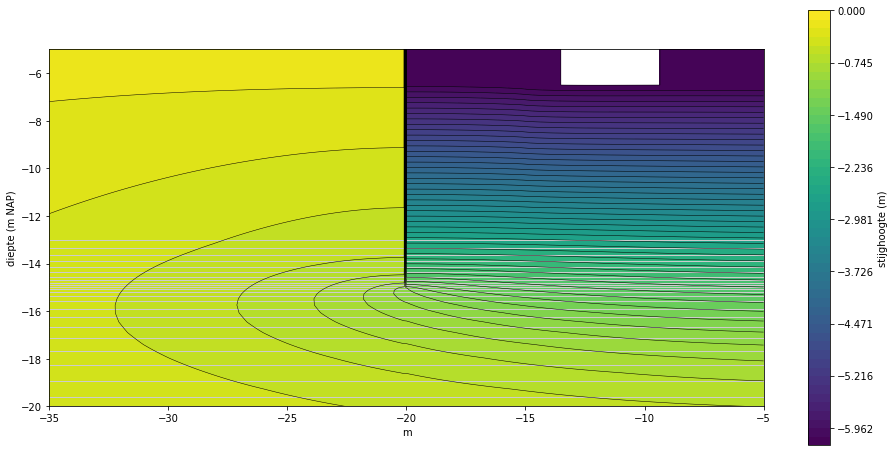

In [59]:
levels = np.linspace(h_bem, -0.0, 51)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ml.plot(win=[x1, x2, y1, y2], orientation="ver", newfig=False)
# ml.vcontoursf1D(x1, x2, n, levels=101, newfig=False, ax=ax, color="r")

cf = ax.contourf(xg, zg, h, levels)
cs = ax.contour(xg, zg, h, levels, colors="k", linewidths=0.5)
# cs2 = ax.contour(xg, zg2, h2, levels, colors="r", linewidths=0.5, linestyles="dashed")

# plt.clabel(cs, fmt="%.2f")
# plt.clabel(cs2, fmt="%.2f")

ax.set_ylim(z_dw-zoffset, z_dw+zoffset)
ax.set_ylabel("diepte (m NAP)");
ax.set_xlabel("m");
ax.set_aspect("equal")

cb = plt.colorbar(cf, ax=ax)
cb.ax.set_ylabel("stijghoogte (m)")

ax.set_ylim(-20, -5)
# ax.set_xlim(-70, -57)